In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


Data import, modified the starter code to used all 5 batches of CIFAR10 

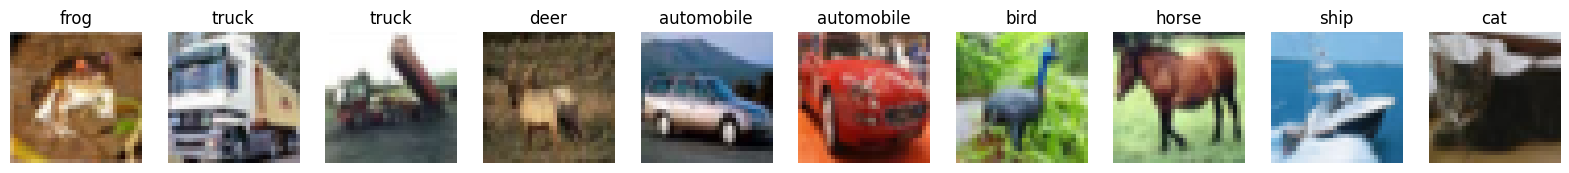

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

train_images_list = []
train_labels_list = []

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

#load whole set
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_images_list.append(batch[b'data'])
    train_labels_list.extend(batch[b'labels'])
train_images = np.concatenate(train_images_list, axis=0)  # Shape (50000, 3072)
train_labels = np.array(train_labels_list)                # Shape (50000,)

# Reshape the images
train_images = train_images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [3]:
print(len(train_images), len(train_labels))

50000 50000


In [4]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

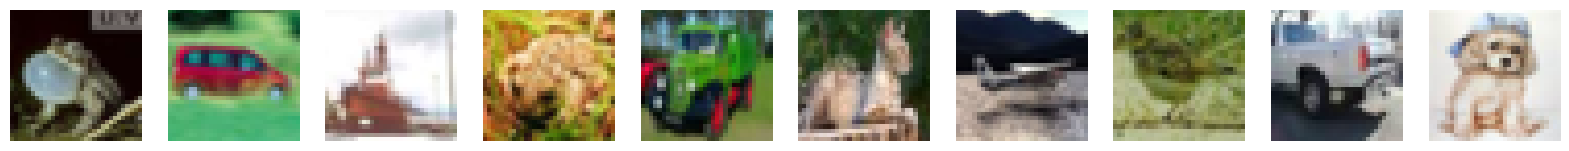

In [5]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

## Data Loading and Augmentation

1. Added 4-pixel padding on each side of the image.
2. Performed random cropping to 32×32 to add spatial variability during training.
3. Applied horizontal flipping with a 50% probability for improved generalization.
4. Normalized images using the dataset mean and standard deviation ([Reference](https://stackoverflow.com/questions/69747119/pytorch-cifar10-images-are-not-normalized)).
5. Split the data into an 80/20 train-validation set.


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
from PIL import Image

# Define transforms for data augmentation and normalization
# normalization reference 
train_transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010]),
])
test_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010]),
])

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # np arr (N, 32, 32, 3)
        self.labels = labels  # list or numpy array of labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# for test data 
class CIFAR10CustomTestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images  # already in (N, W, H, C) format
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform:
            image = self.transform(image)
        return image

train_dataset_full = CIFAR10CustomDataset(train_images, train_labels, transform=train_transform)

# Split training and validation 0.8 testing 0.2 val
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
print(train_size, val_size, train_size + val_size)
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Create DataLoaders
# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_dataset = CIFAR10CustomTestDataset(images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


40000 10000 50000


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from PIL import Image
import glob

# ResidualBlock

- **Purpose:** Implements a residual unit with a skip connection.
- **Main Path:**
  - Conv1: Kernel size `F` (default 3) with given stride → BatchNorm → ReLU.
  - Conv2: Kernel size `F` with stride 1 → BatchNorm.
- **Shortcut:**
  - If dimensions match, uses identity.
  - Otherwise, applies a 1×1 conv (kernel `K`, default 1) with necessary stride → BatchNorm.
- **Output:** Sum of main path and shortcut, then ReLU activated.


In [8]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, config):
        super(ResidualBlock, self).__init__()
        # get kernel size F
        kernel_size = config.get("residual_kernel", 3)
        padding = kernel_size // 2 
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                               stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        skip_kernel = config.get("skip_kernel", 1)
        skip_padding = skip_kernel // 2
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=skip_kernel,
                          stride=stride, padding=skip_padding, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


# ModifiedResNet

- **Purpose:**  
  A configurable ResNet-style network for image classification.

- **Architecture:**  
  - **Initial Layers:**  
    - 2D Convolution with kernel size F, stride 1, and appropriate padding.  
    - Batch Normalization.
  - **Residual Layers:**  
    - Four groups of residual blocks, where the number of blocks in each group is defined by the configuration.  
    - The number of channels doubles after each group.
  - **Final Layers:**  
    - Adaptive Average Pooling to produce a fixed-size output.  
    - Dropout (p=0.5) for regularization.  
    - Fully Connected layer mapping to the desired number of classes.

- **Forward Pass:**  
  - Input → Initial Conv + BN + ReLU → Four Residual Layers → Adaptive Avg Pool → Dropout → Flatten → FC Layer.


In [9]:
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=10, config=None):
        super(ModifiedResNet, self).__init__()
        # Default configuration
        if config is None:
            config = {
                "base_channels": 64,            # C
                    "block_configuration": [2, 3, 2],  # Number of blocks Bi
                "residual_kernel": 3,           # F
                "skip_kernel": 1,               # K
                "pool_size": (1, 1)             # P
            }
        self.config = config
        self.in_channels = config["base_channels"]
        
        kernel_size = config.get("residual_kernel", 3)
        padding = kernel_size // 2
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=kernel_size,
                               stride=1, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        # Create layers
        # Channels double after each group.
        block_config = config["block_configuration"]
        channels = [config["base_channels"] * (2**i) for i in range(len(block_config))]
        self.layer1 = self._make_layer(channels[0], block_config[0], stride=1, config=config)
        self.layer2 = self._make_layer(channels[1], block_config[1], stride=2, config=config)
        self.layer3 = self._make_layer(channels[2], block_config[2], stride=2, config=config)
        # self.layer4 = self._make_layer(channels[3], block_config[3], stride=2, config=config)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(config.get("pool_size", (1, 1)))
        self.fc = nn.Linear(channels[2], num_classes)
    
    def _make_layer(self, out_channels, num_blocks, stride, config):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, config))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1, config=config))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)


# Configurations for Modified ResNet

- **Base Channels (C):** Set to 68  
  *Tuning Note:* Increased from a lower value to boost feature extraction capacity while staying within the parameter budget.

- **Block Configuration (Bi):** `[2, 3, 3]`  
  *Tuning Note:* This layout balances network depth and parameter count, ensuring sufficient hierarchical feature learning.

- **Residual Kernel (F):** 3  
  *Tuning Note:* no change

- **Skip Kernel (K):** 1  
  *Tuning Note:* no change

- **Pool Size (P):** (1, 1)  
  *Tuning Note:* no change

**Implementation Steps:**

- Configured the `ModifiedResNet` model with the above hyperparameters.
- Moved the model to the GPU if available.
- Verified the architecture and parameter count using `torchsummary.summary`.


In [10]:
my_config = {
    "base_channels": 68, #C
    "block_configuration": [2, 3, 3],  #Bi 
    "residual_kernel": 3,#F
    "skip_kernel": 1,#K
    "pool_size": (1, 1)#P
}
model = ModifiedResNet(num_classes=10,config=my_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 68, 32, 32]           1,836
       BatchNorm2d-2           [-1, 68, 32, 32]             136
            Conv2d-3           [-1, 68, 32, 32]          41,616
       BatchNorm2d-4           [-1, 68, 32, 32]             136
            Conv2d-5           [-1, 68, 32, 32]          41,616
       BatchNorm2d-6           [-1, 68, 32, 32]             136
     ResidualBlock-7           [-1, 68, 32, 32]               0
            Conv2d-8           [-1, 68, 32, 32]          41,616
       BatchNorm2d-9           [-1, 68, 32, 32]             136
           Conv2d-10           [-1, 68, 32, 32]          41,616
      BatchNorm2d-11           [-1, 68, 32, 32]             136
    ResidualBlock-12           [-1, 68, 32, 32]               0
           Conv2d-13          [-1, 136, 16, 16]          83,232
      BatchNorm2d-14          [-1, 136,

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
   
train_config = {
    "optimizer": "sgd",       # sgd
    "lr": 0.1,                # learning rate
    "momentum": 0.9,          # Momentum 
    "weight_decay": 5e-4,     # L2 regularization 
    "batch_size": 128,        # Batch size
    "num_epochs": 200,        # Number of training epochs
    "scheduler": "cosine",      # step or cosine
    "step_size": 50,          # epchos before decay
    "warmup_epochs": 5 ,
    "gamma": 0.1             # gamma
}
# place holder for adam
train_config_adam = {
    "optimizer": "adam",         # Optimizer type.
    "lr": 0.001,                 # Learning rate for Adam 
    "batch_size": 64,            # Batch size.
    "num_epochs": 50,            # EPOCHOS
    "scheduler": "step",         # step or cosine
    "step_size": 20,            
    "gamma": 0.5,                
    "weight_decay": 0            # Weight decay 
}
train_loader = DataLoader(train_dataset, batch_size=train_config["batch_size"], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=train_config["batch_size"], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=train_config["batch_size"], shuffle=False, num_workers=2)

- **Purpose:** Implements a learning rate schedule that combines a warm-up phase with cosine annealing.
  - Formula: `lr = (epoch + 1) / warmup_epochs`
  - Formula:  
    `lr = 0.5 * (1 + cos( π * (epoch - warmup_epochs) / (num_epochs - warmup_epochs) ))`
- **Usage:**  
  The returned scaling factor is used to adjust the base learning rate for each epoch.


In [12]:
# warm-up epochs + cos annealing
import math
def lr_lambda(epoch):
    if epoch < train_config["warmup_epochs"]:
        # Linearly increase learning rate from 0 to 1 during warmup.
        return float(epoch + 1) / train_config["warmup_epochs"]
    else:
        # Cosine annealing for the remaining epochs.
        return 0.5 * (1 + math.cos(math.pi * (epoch - train_config["warmup_epochs"]) / (train_config["num_epochs"] - train_config["warmup_epochs"])))

In [13]:
criterion = nn.CrossEntropyLoss()
if train_config["optimizer"] == "sgd":
    optimizer = optim.SGD(model.parameters(),
                          lr=train_config["lr"],
                          momentum=train_config["momentum"],
                          weight_decay=train_config["weight_decay"])
else:
    optimizer = optim.Adam(model.parameters(), lr=train_config["lr"])
if train_config["scheduler"] == "step":
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=train_config["step_size"], gamma=train_config["gamma"])
elif train_config["scheduler"] == "cosine":
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
else:
    scheduler = None
print("Training configuration:")
for key, value in train_config.items():
    print(f"{key}: {value}")

Training configuration:
optimizer: sgd
lr: 0.1
momentum: 0.9
weight_decay: 0.0005
batch_size: 128
num_epochs: 200
scheduler: cosine
step_size: 50
warmup_epochs: 5
gamma: 0.1


In [14]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} Batch {batch_idx} Loss: {loss.item():.4f}')
    train_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {accuracy:.2f}%')
    return train_loss, accuracy

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_loss / len(val_loader)
    accuracy = 100. * correct / total
    print(f'Validation Loss: {val_loss:.4f} | Validation Acc: {accuracy:.2f}%')
    return val_loss, accuracy


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, train_config["num_epochs"] + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if scheduler is not None:
        scheduler.step()

Epoch 1 Batch 0 Loss: 2.3243
Epoch 1 Batch 100 Loss: 1.5550
Epoch 1 Batch 200 Loss: 1.2422
Epoch 1 Batch 300 Loss: 1.2598
Train Loss: 1.5687 | Train Acc: 42.03%
Validation Loss: 1.3909 | Validation Acc: 49.72%
Epoch 2 Batch 0 Loss: 1.3975
Epoch 2 Batch 100 Loss: 1.4176
Epoch 2 Batch 200 Loss: 1.2479
Epoch 2 Batch 300 Loss: 1.1691
Train Loss: 1.1972 | Train Acc: 56.84%
Validation Loss: 1.2797 | Validation Acc: 55.82%
Epoch 3 Batch 0 Loss: 1.0336
Epoch 3 Batch 100 Loss: 0.9181
Epoch 3 Batch 200 Loss: 0.9394
Epoch 3 Batch 300 Loss: 0.9015
Train Loss: 0.9419 | Train Acc: 66.66%
Validation Loss: 0.8782 | Validation Acc: 69.29%
Epoch 4 Batch 0 Loss: 1.1883
Epoch 4 Batch 100 Loss: 0.8067
Epoch 4 Batch 200 Loss: 0.7363
Epoch 4 Batch 300 Loss: 0.7577
Train Loss: 0.7904 | Train Acc: 72.38%
Validation Loss: 0.7716 | Validation Acc: 73.21%
Epoch 5 Batch 0 Loss: 0.6216
Epoch 5 Batch 100 Loss: 0.8558
Epoch 5 Batch 200 Loss: 0.6623
Epoch 5 Batch 300 Loss: 0.7328
Train Loss: 0.6894 | Train Acc: 76.09%

## Plotting Loss and Accuracy

Loss and Accuracy for Validation and Training datasets are plotted using Matplotlib


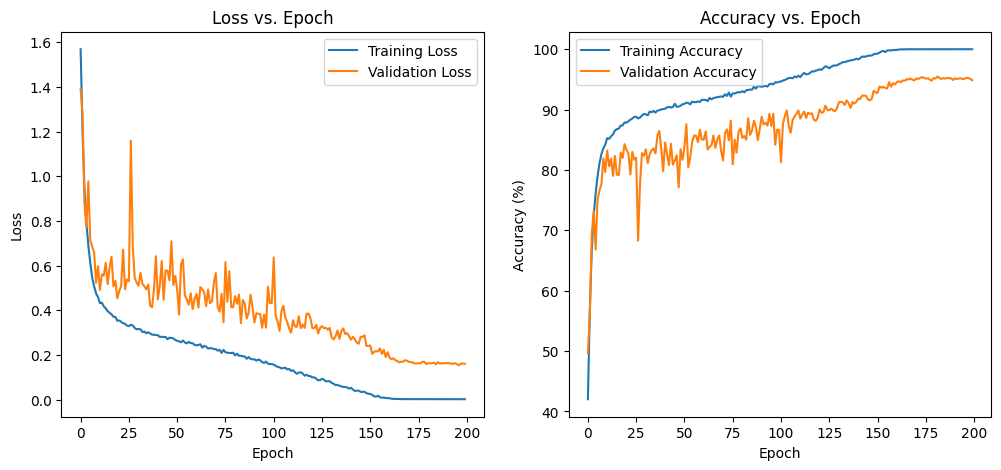

In [16]:
plt.figure(figsize=(12, 5))
epochs = np.arange(train_config["num_epochs"])
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.show()

In [17]:
val_loss, val_acc = validate(model, device, val_loader, criterion)
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Loss: 0.1604 | Validation Acc: 95.22%
Validation Accuracy: 95.22%


In [18]:
def test_inference(model, device, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

test_preds = test_inference(model, device, test_loader)
# print(test_preds)

# Generate submission file
submission = pd.DataFrame({'ID': np.arange(len(test_preds)), 'Labels': test_preds})
submission.to_csv('/kaggle/working/submission1.csv', index=False)
print("Submission1 file saved.")

Submission1 file saved.
